# 0. Dependências

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import MeanShift
from scipy.spatial.distance import cdist

%matplotlib inline

# 1. Introdução 

**Meanshift** é um algoritmo de clusterização que atribui pontos à clusters iterativamente deslocando-os em direção à moda. A moda pode ser entendida como a região de maior densidade de pontos. O Meanshift considera o espaço de atributos com uma função de densidade de probabilidade empírica. Se a entrada é um conjunto de pontos, o Meanshift considera que tais pontos foram amostrados de uma FDP implícita. 

Dado um conjunto de pontos, cada ponto é atribuído em direção a _centroid_ do cluster mais próximo. A direção para o centróide do cluster mais próximo é determinada pelo local onde a maioria dos pontos se encontram próximo aquele cluster. Portanto, a cada iteração, cada ponto será movido em direção à onde a maioria dos pontos estão, que é ou será levado ao centro do cluster. Quando o algoritmo termina, cada ponto é atribuido a um cluster.

**Vantagens:**
- Diferentemente do K-Means, o MeanShift não requer que a quantidade de clusters seja pré-determinada; A #clusters é determinada pelo algoritmo de acordo com os dados.

**Desvantagens:**
- É mais caro computacionalmente que o K-Means. O Meanshift tem complexidade $O(Tn^2)$, onde $T$ é #iterações e $n$ é a #pontos; enquanto o K-Means é $O(knT)$, onde $k$ é a quantidade de clusters.

## Algoritmo básico

Antes de implementar o MeanShift, você precisará de duas funções:

1. Um função $N(x)$ para determinar os vizinhos de um determinado ponto $x \in X$. Somente os pontos dentro de um determinado raio são considerados vizinhos. A métrica para o cálculo de distânca é, em geral, a **distância euclideana**.
2. Um kernel $K(d)$, onde $d$ representa a distância entre dois pontos. Um kernel é uma palavra matemática chique para função de ponderação. O kernel mais popular na implementação do MeanShift é o [Kernel Gaussiano](https://en.wikipedia.org/wiki/Radial_basis_function_kernel), também conhecido com **RBF**.

Com isso em mãos, o algoritmo básico do MeanShift é:

1. Para cada ponto $x \in X$, encontre os pontos vizinhos de x $N(x)$;
2. Para cada ponto vizinho, calcule o **mean shift** $m(x)$ a partir da seguinte equação:

$$\large
m(x) = \frac{\sum_{x_i \in N(x)} K(x_i - x)x_i}{\sum_{x_i \in N(x)}K(x_i - x)}
$$

3. Para cada ponto $x \in X$, atualize $x \leftarrow m(x)$;
4. Repita os passos 1-3 até que todos os pontos não sejam mais atualizados ou praticamente atualizados.


Na prática, a fórmula de $m(x)$ torna-se o seguinte:

$$
m(x) = \frac{\sum_i w_ix_i}{\sum_i w_i}
$$

Ou seja, o Meanshift é calculado pela **média ponderada dos pontos afetados em relação a $x$**.

> Resumindo, o algoritmo encontra um conjunto de pontos vizinhos a um determinado ponto no dataset. Esse vizinhos são, então, deslocados para onde a maior parte de pontos se encontram. Os pontos mais próximos exercem mais influência que os pontos mais distantes. Repita esse procedimento até que nenhum ponto (praticamente) mude.

<img src='images/meanshift.gif' width=500>

# 2. Dados

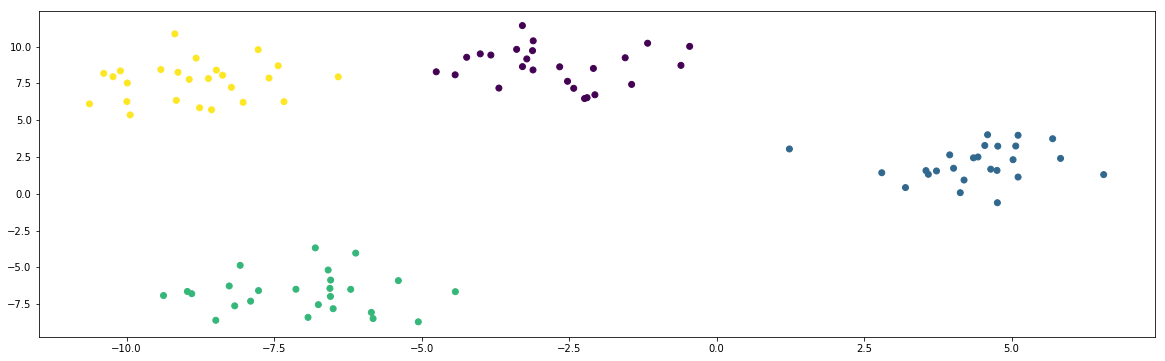

In [2]:
x, y = make_blobs(100, 2, centers=4, cluster_std=1.3, random_state=42)

plt.figure(figsize=(20, 6))
plt.scatter(x[:,0], x[:,1], c=y)

# 3. Implementação 

In [3]:
def euclidean_distance(a, b):
    return np.sqrt(np.sum((np.array(a) - np.array(b))**2, axis=1))

def gaussian_kernel(d, bandwidth):
    return np.exp(-0.5 * (d / bandwidth)**2) / (bandwidth * np.sqrt(2 * np.pi))

In [4]:
class Mean_Shift():
    def __init__(self, bandwidth, radius=None):
        self.bandwidth = bandwidth
        self.radius = self.bandwidth if radius is None else radius
    
    def fit(self, x):
        centroids = np.array(x).copy()
        centroids_last = np.zeros(x.shape)
        
        while not np.allclose(centroids, centroids_last, rtol=1e-10, atol=1e-10):
            centroids_last = centroids.copy()
            
            for i, centroid in enumerate(centroids):
                distances = euclidean_distance(centroid, x)
                neighbours = x[distances <= self.radius]
                distances = distances[distances <= self.radius]
                
                weights = gaussian_kernel(distances, self.bandwidth).reshape(-1, 1)
                centroids[i] = np.sum(weights * neighbours, axis=0) / weights.sum()
                
        self.cluster_centers_ = np.unique(np.round(centroids, decimals=9), axis=0)
        
    def predict(self, x):
        pass

# 4. Teste 

O scikit-learn considera o ```radius = bandwith``` ([fonte](https://github.com/scikit-learn/scikit-learn/blob/7b136e9/sklearn/cluster/mean_shift_.py#L200)).

In [5]:
mean_shift = Mean_Shift(bandwidth=4, radius=4)
mean_shift.fit(x)

print(mean_shift.cluster_centers_)

[[-8.86465937  7.60324596]
 [-7.01743419 -6.75541713]
 [-2.88956922  8.6321642 ]
 [ 4.40408214  2.03718284]]


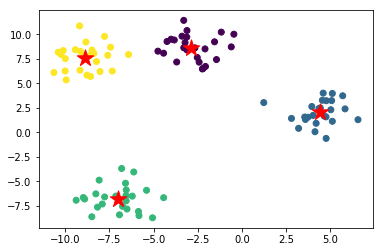

In [6]:
plt.scatter(x[:, 0], x[:, 1], c=y)
plt.scatter(mean_shift.cluster_centers_[:, 0], mean_shift.cluster_centers_[:, 1], c='red', marker='*', s=300)

## Comparação com o Scikit-learn

In [7]:
mean_shift_sk = MeanShift(bandwidth=4)
mean_shift_sk.fit(x)

print(mean_shift_sk.cluster_centers_)

[[-2.89568058  8.63436515]
 [ 4.38577929  2.03563702]
 [-7.00354281 -6.73010269]
 [-8.85949753  7.61545028]]


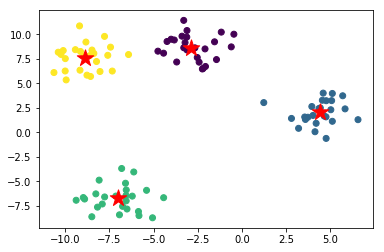

In [8]:
plt.scatter(x[:, 0], x[:, 1], c=y)
plt.scatter(mean_shift_sk.cluster_centers_[:, 0], mean_shift_sk.cluster_centers_[:, 1], c='red', marker='*', s=300)

## 5. Referências

- [Mean Shift Clustering](https://spin.atomicobject.com/2015/05/26/mean-shift-clustering/)
- [Meanshift Algorithm for the Rest of Us (Python)](http://www.chioka.in/meanshift-algorithm-for-the-rest-of-us-python/)
- [Introduction To Mean Shift Algorithm](https://saravananthirumuruganathan.wordpress.com/2010/04/01/introduction-to-mean-shift-algorithm/)